# Total Factor of Productivity (TFP)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrds
db = wrds.Connection()

In [2]:
dt = pd.read_csv('../data/TFPData_updated.csv')

In [3]:
comp = db.raw_sql("""
                    select gvkey, tic, conm, datadate, fyear, sich, prcc_f, csho,
                    at, aqc, ppegt, ppent, emp, capx, capxv, sale, cogs, xad, xrd, xsga,
                    pstkl, txditc,
                    pstkrv, seq, pstk, mkvalt
                    from comp.funda
                    where 
                    (sale > 0 or at > 0)
                    and indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and curcd='USD'
                    and datadate >= '1963-01-01'
                    and fic='USA'
                    and final='Y'
                    """)

In [7]:
dt.TFP.describe()

count    143912.000000
mean         -0.325610
std           0.449125
min          -5.487288
25%          -0.513174
50%          -0.306304
75%          -0.109718
max           3.402086
Name: TFP, dtype: float64

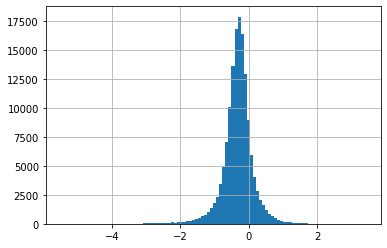

In [8]:
dt.TFP.hist(bins=100)

In [9]:
dt_TFP_frontier_yearly = dt.groupby('fyear')[['TFP']].max()
dt_TFP_mean_yearly = dt.groupby('fyear')[['TFP']].mean()
dt_TFP_median_yearly = dt.groupby('fyear')[['TFP']].median()

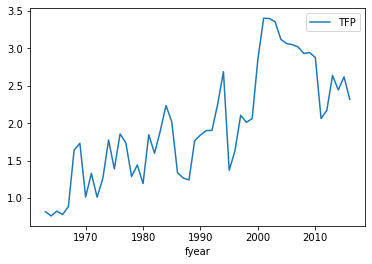

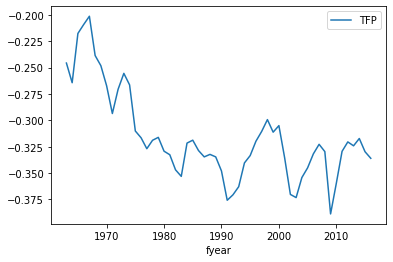

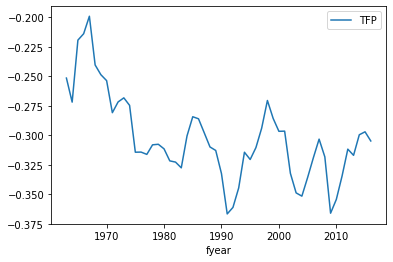

In [10]:
dt_TFP_frontier_yearly.plot()
dt_TFP_mean_yearly.plot()
dt_TFP_median_yearly.plot()

In [11]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

comp['txditc']=comp['txditc'].fillna(0)

# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [12]:
# create market value
comp['me']=comp['prcc_f']*comp['csho']

In [13]:
# compare me and mkvalt
comp[comp.tic=='MSFT'][['fyear','mkvalt','me','sich']]

,fyear,mkvalt,me,sich
188926,1985.0,NaN,NaN,NaN
188927,1986.0,NaN,7.847394e+02,NaN
188928,1987.0,NaN,2.688411e+03,7372.0
188929,1988.0,NaN,3.595418e+03,7372.0
188930,1989.0,NaN,2.893054e+03,7372.0
188931,1990.0,NaN,8.641114e+03,7372.0
188932,1991.0,NaN,1.186969e+04,7372.0
188933,1992.0,NaN,1.904973e+04,7372.0
188934,1993.0,NaN,2.481600e+04,7372.0
188935,1994.0,NaN,2.999412e+04,7372.0


In [14]:
comp['gvkey']=comp.gvkey.astype('int')

# Merge

In [15]:
df=pd.merge(dt,comp, on=['gvkey','fyear'])

In [16]:
df.shape

(131913, 30)

In [17]:
df=df[df['sich'].notna()]

In [18]:
df.shape

(81059, 30)

In [19]:
#df= df[~((df.sich >= 4900) & (df.sich < 5000))]
#df= df[~((df.sich >= 6000) & (df.sich < 7000))]

In [20]:
df.shape

(81059, 30)

In [21]:
#df=df[(df.aqc <= (0.05 * df['at']))]

In [22]:
df.shape

(81059, 30)

In [23]:
# clip TFP
lr = df['TFP'].describe(percentiles=[0.005])['0.5%']
up = df['TFP'].describe(percentiles=[0.995])['99.5%']
df.TFP = df.TFP.clip(lr, up)

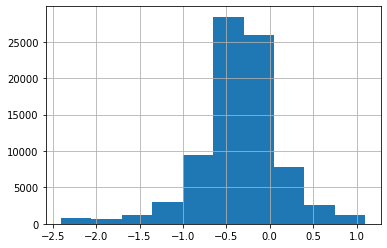

In [24]:
df.TFP.hist()

In [25]:
df.loc[df.index,'TFP_frontier_fyear_sich'] = df.groupby(['fyear', 'sich'])['TFP'].transform(max)
df.loc[df.index,'TFP_mean_fyear_sich'] = df.groupby(['fyear', 'sich'])['TFP'].transform(np.mean)
df.loc[df.index,'TFP_median_fyear_sich'] = df.groupby(['fyear', 'sich'])['TFP'].transform(np.median)

In [26]:
df.loc[df.index,'gap'] = df['TFP_frontier_fyear_sich'] - df['TFP']

In [27]:
df.groupby('fyear').gap.nunique()

fyear
1984       1
1985       1
1986       1
1987    2266
1988    2342
1989    2332
1990    2319
1991    2327
1992    2420
1993    2537
1994    2722
1995    2909
1996    2957
1997    3112
1998    3187
1999    3099
2000    2832
2001    2663
2002    2608
2003    2600
2004    2518
2005    2420
2006    2293
2007    2144
2008    2080
2009    2019
2010    1993
2011    1909
2012    1845
2013    1795
2014    1770
2015    1700
2016    1621
Name: gap, dtype: int64

In [28]:
df=df[df.fyear>=1987]

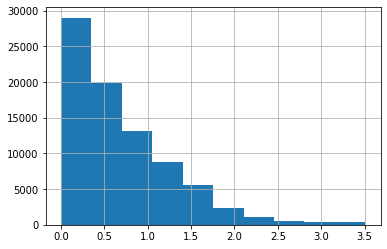

In [29]:
df.gap.hist()

In [30]:
df=df[df['be'].notna()]
df=df[df['me'].notna()]

df=df[df['be']>0]
df=df[df['me']>0]

In [31]:
df.shape

(72325, 34)

In [32]:
df['beme'] = df['be']/df['me']

In [33]:
df['beme'].describe()

count     72325.000000
mean         14.687726
std        1399.953527
min           0.000052
25%           0.323019
50%           0.548565
75%           0.899677
max      267639.093318
Name: beme, dtype: float64

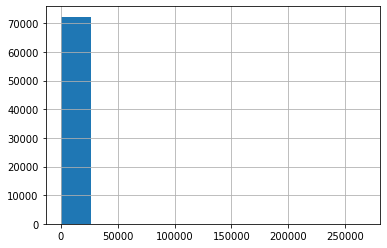

In [34]:
df['beme'].hist()

In [35]:
df[['gap', 'beme']].corr()

,gap,beme
gap,1.000000,-0.005425
beme,-0.005425,1.000000


In [36]:
from scipy.stats.mstats import winsorize

In [37]:
df['beme'].describe()

count     72325.000000
mean         14.687726
std        1399.953527
min           0.000052
25%           0.323019
50%           0.548565
75%           0.899677
max      267639.093318
Name: beme, dtype: float64

In [38]:
lr = df['beme'].describe(percentiles=[0.005])['0.5%']
up = df['beme'].describe(percentiles=[0.995])['99.5%']
df.beme = df.beme.clip(lr, up)

In [39]:
df.shape

(72325, 35)

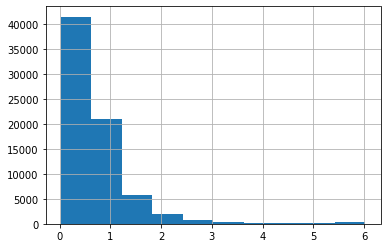

In [40]:
df.beme.hist()

In [41]:
# clip gap
# lr = df['gap'].describe(percentiles=[0.005])['0.5%']
# up = df['gap'].describe(percentiles=[0.995])['99.5%']
# df.gap = df.gap.clip(lr, up)

In [42]:
df[['gap', 'beme']].corr()

,gap,beme
gap,1.000000,0.079875
beme,0.079875,1.000000


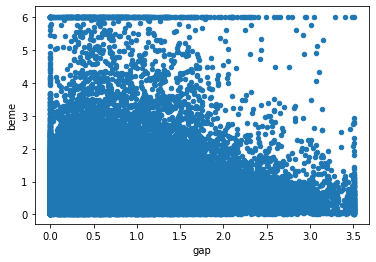

In [43]:
df.plot.scatter(x='gap', y='beme')

# Panel Regressions

In [44]:
from linearmodels import PanelOLS

In [45]:
df=df.set_index(['gvkey','fyear'])

In [46]:
df['size'] = np.log(df['at'])

In [47]:
mod = PanelOLS.from_formula('beme ~ 1 + gap + np.log(gap+0.0001) + size + EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='kernel')
print(res)

/Users/shinggg/anaconda3/lib/python3.6/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PanelOLS Estimation Summary                           
Dep. Variable:                   beme   R-squared:                        0.0284
Estimator:                   PanelOLS   R-squared (Between):             -0.1131
No. Observations:               72325   R-squared (Within):               0.0274
Date:                Wed, Dec 09 2020   R-squared (Overall):             -0.0579
Time:                        15:04:27   Log-likelihood                -5.268e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      620.42
Entities:                        8572   P-value                           0.0000
Avg Obs:                       8.4374   Distribution:                 F(3,63721)
Min Obs:                       1.0000                                           
Max Obs:                       30.000   F-statistic (robust):             106.05
                            

In [48]:
mod = PanelOLS.from_formula('beme ~ 1 + gap + size + ppent+ emp+ capx+ sale+ cogs+ xrd+ xsga+ EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='kernel')
print(res)

/Users/shinggg/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   beme   R-squared:                        0.0299
Estimator:                   PanelOLS   R-squared (Between):             -0.1376
No. Observations:               42854   R-squared (Within):               0.0221
Date:                Wed, Dec 09 2020   R-squared (Overall):             -0.0863
Time:                        15:04:37   Log-likelihood                -2.607e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      128.77
Entities:                        5235   P-value                           0.0000
Avg Obs:                       8.1861   Distribution:                 F(9,37581)
Min Obs:                       1.0000                                           
Max Obs:                       30.000   F-statistic (robust):             64.460
                            

In [49]:
mod = PanelOLS.from_formula('beme ~ 1 + TFP + size + ppent + np.sqrt(emp) + np.log(capx)+ np.log(sale)+ EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='kernel')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   beme   R-squared:                        0.0628
Estimator:                   PanelOLS   R-squared (Between):             -0.0617
No. Observations:               72324   R-squared (Within):               0.0538
Date:                Wed, Dec 09 2020   R-squared (Overall):              0.0025
Time:                        15:04:42   Log-likelihood                -5.138e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      711.56
Entities:                        8571   P-value                           0.0000
Avg Obs:                       8.4382   Distribution:                 F(6,63718)
Min Obs:                       1.0000                                           
Max Obs:                       30.000   F-statistic (robust):             116.55
                            

# Sort Portfolios

In [50]:
df.head()

TFP   tic                   conm    datadate    sich  \
gvkey fyear                                                              
1003  1987  -0.431265  ANTQ  A.A. IMPORTING CO INC  1988-01-31  5712.0   
1004  1987  -0.094108   AIR               AAR CORP  1988-05-31  5080.0   
      1988   0.093183   AIR               AAR CORP  1989-05-31  5080.0   
      1989  -0.176919   AIR               AAR CORP  1990-05-31  5080.0   
      1990  -0.032442   AIR               AAR CORP  1991-05-31  5080.0   

                prcc_f    csho       at    aqc    ppegt  ...  mkvalt   ps  \
gvkey fyear                                              ...                
1003  1987    2.750000   2.683   16.042  0.000    2.297  ...     NaN  0.0   
1004  1987   25.124977  15.870  284.948  2.749   76.251  ...     NaN  0.0   
      1988   31.249992  16.009  356.391  2.397   85.414  ...     NaN  0.0   
      1989   21.249998  16.082  388.521  0.000  105.646  ...     NaN  0.0   
      1990   14.124999  15.891  379.958  0.000  113.060  ...     NaN  0.0   

                  be          me  TFP_frontier_fyear_sich  \
gvkey fyear                                                 
1003  1987     7.643    7.378250                 0.281900   
1004  1987   158.497  398.733387                -0.020629   
      1988   202.580  500.281128                 0.093183   
      1989   225.548  341.742462                 0.225258   
      1990   231.778  224.460360                 0.429447   

             TFP_mean_fyear_sich  TFP_median_fyear_sich       gap      beme  \
gvkey fyear                                                                   
1003  1987             -0.326508              -0.228664  0.713165  1.035882   
1004  1987             -0.313827              -0.367900  0.073479  0.397501   
      1988             -0.647137              -0.565047  0.000000  0.404932   
      1989             -0.363389              -0.387632  0.402177  0.659994   
      1990             -0.450898              -0.165044  0.461889  1.032601   

                 size  
gvkey fyear            
1003  1987   2.775210  
1004  1987   5.652307  
      1988   5.876028  
      1989   5.962347  
      1990   5.940061  

[5 rows x 34 columns]

In [51]:
df.gap.describe()

count    72325.000000
mean         0.681769
std          0.609012
min          0.000000
25%          0.217167
50%          0.538135
75%          1.011544
max          3.507003
Name: gap, dtype: float64

## Overall sort

In [52]:
dec_dict=df.gap.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_dict()
#dec_dict=df.gap.quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).to_dict()

In [53]:
dec_dict

{0.0: 0.0,
 0.1: 0.0,
 0.2: 0.14798218000000007,
 0.3: 0.28008152,
 0.4: 0.40491684000000006,
 0.5: 0.5381347,
 0.6: 0.69816334,
 0.7: 0.8907903399999999,
 0.8: 1.146864180000002,
 0.9: 1.5108301000000006,
 1.0: 3.5070031300000024}

In [54]:
df.loc[(df.gap >=dec_dict[0.0]) & (df.gap <= dec_dict[0.1]),['gap','TFP','beme']].mean()

gap     0.000000
TFP     0.069846
beme    0.551230
dtype: float64

In [55]:
list(dec_dict.keys())[1::]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [56]:
var_list=['gap','TFP','beme']
overall_sort_dict={}
overall_sort_gap=[]
overall_sort_TFP=[]
overall_sort_beme=[]

for i in range(0,10):
    decile = list(dec_dict.keys())[1::][i]
    if i == 0:
        print('decile = 0.1')
        overall_sort_gap.append(df.loc[(df.gap >=dec_dict[0]) & (df.gap <= dec_dict[decile]),var_list].mean()['gap'])
        overall_sort_TFP.append(df.loc[(df.gap >=dec_dict[0]) & (df.gap <= dec_dict[decile]),var_list].mean()['TFP'])
        overall_sort_beme.append(df.loc[(df.gap >=dec_dict[0]) & (df.gap <= dec_dict[decile]),var_list].mean()['beme'])
    else:
        print(decile)
        decile0 = list(dec_dict.keys())[1::][i-1]
        overall_sort_gap.append(df.loc[(df.gap >dec_dict[decile0]) & (df.gap <= dec_dict[decile]),var_list].mean()['gap'])
        overall_sort_TFP.append(df.loc[(df.gap >dec_dict[decile0]) & (df.gap <= dec_dict[decile]),var_list].mean()['TFP'])
        overall_sort_beme.append(df.loc[(df.gap >dec_dict[decile0]) & (df.gap <= dec_dict[decile]),var_list].mean()['beme'])
        
overall_sort_dict['gap']=overall_sort_gap
overall_sort_dict['TFP']=overall_sort_TFP
overall_sort_dict['beme']=overall_sort_beme

decile = 0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [57]:
overall_sort_dict

{'gap': [0.0,
  0.08126241382307837,
  0.2161130317848747,
  0.34175294932245404,
  0.47056498122908785,
  0.6163209772262178,
  0.7910004487555312,
  1.0139090567952436,
  1.31551563991012,
  1.986551215342181],
 'TFP': [0.06984639256571322,
  -0.10640468839270496,
  -0.17981913251762704,
  -0.2367593454922573,
  -0.28240725097884756,
  -0.3172850770188045,
  -0.3653694722483406,
  -0.4209412099543765,
  -0.5340090016219599,
  -1.092071573257293],
 'beme': [0.551229708959103,
  0.5866325442355682,
  0.6690314817782578,
  0.7724877361214887,
  0.8003492825899973,
  0.817559166191154,
  0.8280355829835762,
  0.7957368316269418,
  0.780951113439649,
  0.7998909769621214]}

In [58]:
overall_sort_df=pd.DataFrame(overall_sort_dict)

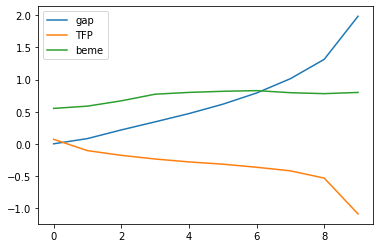

In [59]:
overall_sort_df.plot()

In [60]:
overall_sort_df.loc[9]-overall_sort_df.loc[0]

gap     1.986551
TFP    -1.161918
beme    0.248661
dtype: float64

## Sort within year then average across year

In [61]:
df.reset_index(inplace=True)

In [62]:
df.groupby('fyear').gap.max()

fyear
1987    3.474747
1988    3.088267
1989    3.380330
1990    3.362662
1991    3.317052
1992    3.435909
1993    3.507003
1994    3.507003
1995    3.382395
1996    3.507003
1997    3.507003
1998    3.507003
1999    3.507003
2000    3.507003
2001    3.507003
2002    3.507003
2003    3.507003
2004    3.507003
2005    3.507003
2006    3.507003
2007    3.507003
2008    3.507003
2009    3.507003
2010    3.507003
2011    3.507003
2012    3.507003
2013    3.507003
2014    3.507003
2015    3.507003
2016    3.507003
Name: gap, dtype: float64

In [63]:
dec_year_dict=df[df.fyear==1987].gap.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_dict()

In [64]:
dec_year_dict

{0.0: 0.0,
 0.1: 0.0,
 0.2: 0.10260216000000001,
 0.3: 0.20543173,
 0.4: 0.29768806000000003,
 0.5: 0.40120544999999996,
 0.6: 0.5038151799999999,
 0.7: 0.63767706,
 0.8: 0.81593544,
 0.9: 1.0901089399999997,
 1.0: 3.47474653}

In [65]:
df[df.fyear==1987].loc[(df[df.fyear==1987].gap >dec_year_dict[0.1]) & (df[df.fyear==1987].gap <= dec_year_dict[0.2]), ['gap','TFP','beme']].mean()

gap     0.053158
TFP    -0.103950
beme    0.664173
dtype: float64

In [66]:
list(dec_year_dict.keys())[1::]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [67]:
len(set(df.fyear))

30

In [68]:
var_list=['gap','TFP','beme']
for year in set(df.fyear):
    overall_sort_dict={}
    overall_sort_gap=[]
    overall_sort_TFP=[]
    overall_sort_beme=[]
    dec_year_dict=df[df.fyear==year].gap.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_dict()
    print(year)

    for i in range(0,10):
        decile = list(dec_year_dict.keys())[1::][i]
        if i == 0:
            #print('decile = 0.1')
            overall_sort_gap.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >=dec_year_dict[0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['gap'])
            overall_sort_TFP.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >=dec_year_dict[0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['TFP'])
            overall_sort_beme.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >=dec_year_dict[0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['beme'])
        else:
            #print(decile)
            decile0 = list(dec_year_dict.keys())[1::][i-1]
            overall_sort_gap.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >dec_year_dict[decile0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['gap'])
            overall_sort_TFP.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >dec_year_dict[decile0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['TFP'])
            overall_sort_beme.append(df[df.fyear==year].loc[(df[df.fyear==year].gap >dec_year_dict[decile0]) & (df[df.fyear==year].gap <= dec_year_dict[decile]), var_list].mean()['beme'])

    overall_sort_dict['gap']=overall_sort_gap
    overall_sort_dict['TFP']=overall_sort_TFP
    overall_sort_dict['beme']=overall_sort_beme

    if year==1987:
        overall_sort_df=pd.DataFrame(overall_sort_dict)
    else:
        overall_sort_df+=pd.DataFrame(overall_sort_dict)

overall_sort_df=overall_sort_df/len(set(df.fyear))

1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


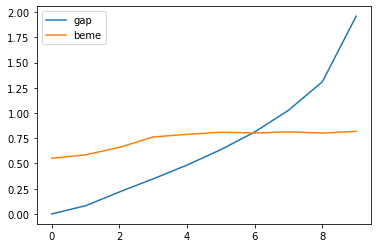

In [69]:
overall_sort_df[['gap','beme']].plot()

In [70]:
overall_sort_df

,gap,TFP,beme
0,6.378312e-07,0.070642,0.551527
1,8.094429e-02,-0.104564,0.585342
2,2.178016e-01,-0.177206,0.659687
3,3.477230e-01,-0.234649,0.762581
4,4.843775e-01,-0.269769,0.788731
5,6.372708e-01,-0.315328,0.809571
6,8.121798e-01,-0.367529,0.802097
7,1.027471e+00,-0.430668,0.813111
8,1.309759e+00,-0.548866,0.801563
9,1.959153e+00,-1.106878,0.818612


In [71]:
overall_sort_df.corr()

,gap,TFP,beme
gap,1.000000,-0.969904,0.736410
TFP,-0.969904,1.000000,-0.692493
beme,0.736410,-0.692493,1.000000


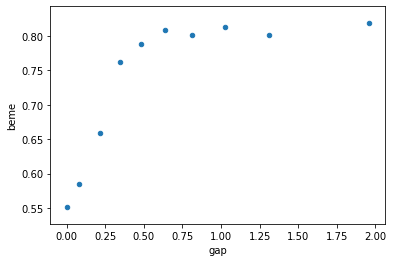

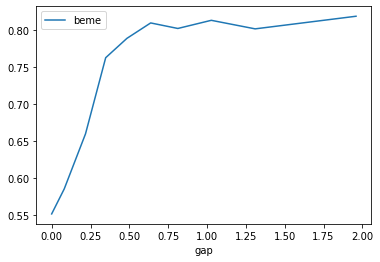

In [72]:
overall_sort_df.plot.scatter(y='beme',x='gap')
overall_sort_df.plot.line(y='beme',x='gap')